In [ ]:
############################# - Notes for use to avoid confusion :)


#Not all cells work together. For example if you run the cell that deals with missing values by removing the entire row
#or removing all columns you will not be able to use the method to predict null values because the entries will be gone.

#So in order to predict the missing values after using the code cells that remove them you simply have to first run the code cell
#which reads the original data again

#Websites:
    #preporcessing methods outline - https://blog.ml.cmu.edu/2020/08/31/2-data-exploration/
    #outliers simple - https://analyticsindiamag.com/how-to-detect-and-treat-outliers-in-categorical-data/
    #pca collinearity removal/heatmap - https://towardsdatascience.com/how-do-you-apply-pca-to-logistic-regression-to-remove-multicollinearity-10b7f8e89f9b#:~:text=PCA%20in%20action%20to%20remove%20multicollinearity&text=PCA%20(Principal%20Component%20Analysis)%20takes,effectively%20eliminate%20multicollinearity%20between%20features.
    #vif - https://towardsdatascience.com/how-to-remove-multicollinearity-using-python-4da8d9d8abb2
    #pca 2D - https://towardsdatascience.com/principal-component-analysis-pca-from-scratch-in-python-7f3e2a540c51
    #pca 3D - https://drzinph.com/pca-visualized-with-3d-scatter-plots/
    #tsne -https://builtin.com/data-science/tsne-python
    #umap - https://blog.ml.cmu.edu/2020/08/31/2-data-exploration/
    #automatic outlier detection - https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/
    #3D tsne and umap -  https://plotly.com/python/t-sne-and-umap-projections/#project-data-into-3d-with-tsne-and-pxscatter3d
#############################

In [1]:
#missing values have value ? all for attribute 11

#either edible, poisonous or unknown. Unknowm and poisonous grouped together

#to deal with missing values use 'classifier' or 'regressor' based on values that arent missing to predict missing values in
#preprocessing. Be careful that vlaues using to predict arent overfitted. Compare to other methods such as removing entire attribute
#or giving deafult/mean value

from sklearn import metrics
from sklearn import model_selection
from sklearn import ensemble
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# visualisation imports
# separated to reduce import time

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import umap.umap_ as umap

from statsmodels.stats.outliers_influence import variance_inflation_factor

import plotly.express as px

c:\Users\Kai Heale\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


__Preprocessing__

In [12]:
# read contents of data file
file = pd.read_csv("agaricus-lepiota.data", header = None)

# create list to be used as headers
features = ['edibility', 'capShape', 'capSurface', 'capColor', 'bruises', 'odor', 
            'gillAttachment', 'gillSpacing', 'gillSize', 'gillColor', 
            'stalkShape', 'stalkRoot', 'stalkSurfaceAboveRing', 'stalkSurfaceBelowRing', 
            'stalkColorAboveRing', 'stalkColorBelowRing', 'veilType', 'veilColor', 
            'ringNumber', 'ringType', 'sporePrintColor', 'population', 'habitat']

#convert '?' to NaN
file.replace({'?': np.nan}, inplace=True)

# converting data frame to csv
file.to_csv("agaricus-lepiota.csv", header=features, index=False)

data = pd.read_csv("agaricus-lepiota.csv")

#we can drop veilType as all entries are the same so cannot be used to predict
#print(data.nunique())
#data = data.drop('veilType', axis = 1).reset_index(drop=True)
#features.remove('veilType')

#result = data.head(10)
#print(data)
#print(result)

In [ ]:
#removes column with missing values which in our data is only stalkRoot
#one way to deal with missing values
print(data.shape)

data = data.drop('stalkRoot', axis = 1).reset_index(drop=True)

print(data.shape)

data.to_csv("agaricus-lepiota-no-stalkRoot.csv")

print(data.head(10))

In [ ]:
#removes all rows that have missing values
print(data.shape)

data = data.dropna(axis = 0).reset_index(drop=True)
 
#shows we lose alot of data as 2480 rows lost
#bad way of handling missing values
print(data.shape)

data.to_csv("agaricus-lepiota-NaN-removed.csv")

In [13]:
#use label encoding on all features that are categorical
#OneHot encoding not applicable as there are a high number of categories
le = LabelEncoder()

for i in range(len(features)):
   data[features[i]] = le.fit_transform(data[features[i]])

x = data['ringType'].value_counts()
#print(x.index[4])

#temp = data[data['capShape'] == 4]
#print(temp['capShape'])

data.to_csv("agaricus-lepiota-encoded.csv")

In [14]:
#predict missing values for stalkRoot
NaN_predict = data.drop('edibility', axis = 1).reset_index(drop=True)

NaN_train_data = NaN_predict[NaN_predict['stalkRoot']!= 4].copy()
NaN_test_data = NaN_predict[NaN_predict['stalkRoot'] == 4].copy()

NaN_X_train = NaN_train_data.drop('stalkRoot', axis = 1).reset_index(drop=True)
NaN_y_train = NaN_train_data['stalkRoot']

NaN_X_test = NaN_test_data.drop('stalkRoot', axis = 1).reset_index(drop=True)

###############################################################################################################################
#This code further breaks the data down into training and test sets comprising of rows that have no missing values
#Allows us to run models and check how accurately they can predict the missing values then choose an appropriate one
#In this case both Random Forest and Support Vector Classification predict that exact same values for 'stalkRoot' so either can be used
#Both have 100% accuracy in predicitng 'stalkRoot' so we know when we predict the missing values they will most likely be correct.
X_train, X_test, y_train, y_test = train_test_split(NaN_train_data, NaN_train_data['stalkRoot'], test_size=0.2,random_state=42)

rfr = RandomForestRegressor()
svm = SVC()

rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)

svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

rfr_rounded = (np.rint(rfr_pred)).astype(int)

svm_rounded = (np.rint(svm_pred)).astype(int)

different = []

for i in range(len(rfr_rounded)):
    if rfr_rounded[i] != svm_rounded[i]:
        different.append(rfr_rounded[i], svm_rounded[i])

print(len(different))

print(classification_report(y_test,rfr_rounded))

print(classification_report(y_test,svm_rounded))
##############################################################################################################################

rfc = RandomForestRegressor()

rfc.fit(NaN_X_train,NaN_y_train)
y_pred = rfc.predict(NaN_X_test)

rounded_data = (np.rint(y_pred)).astype(int)
NaN_test_data['stalkRoot'] = rounded_data

NaN_test_data.to_csv("predicted-missing-values.csv")

frames = [NaN_train_data, NaN_test_data]
treated_data = pd.concat(frames)
treated_data.insert(0, column = 'edibility', value = data['edibility'])

baseline_X = data.drop('edibility', axis = 1).reset_index(drop=True)
baseline_y = data['edibility']

X = treated_data.drop('edibility', axis = 1).reset_index(drop=True)
y = treated_data['edibility'] 

data_scaled = StandardScaler().fit_transform(X)

treated_data.to_csv("full-data.csv")

0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       724
           1       1.00      1.00      1.00       119
           2       1.00      1.00      1.00       239
           3       1.00      1.00      1.00        47

    accuracy                           1.00      1129
   macro avg       1.00      1.00      1.00      1129
weighted avg       1.00      1.00      1.00      1129

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       724
           1       1.00      1.00      1.00       119
           2       1.00      1.00      1.00       239
           3       1.00      1.00      1.00        47

    accuracy                           1.00      1129
   macro avg       1.00      1.00      1.00      1129
weighted avg       1.00      1.00      1.00      1129



(8124, 23)
(7619, 23)


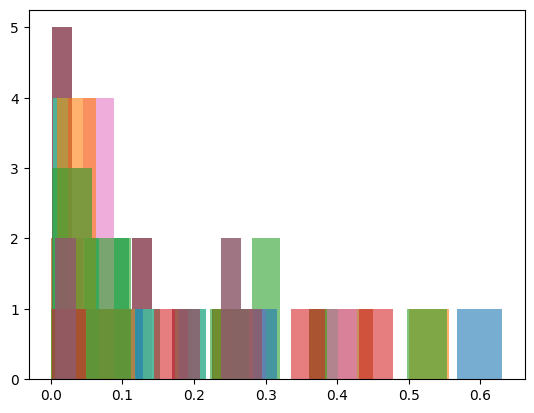

In [15]:
# define outliers as values a category can take which is significantly more or less frequent than the others

threshold = 0.01 # decides relative frequency threshold, below which values are considered outliers
contains_outliers = []
num_values = data.nunique()

print(treated_data.shape)

# loop through categories and identify which contain outliers according to the above definitions
for i in range(len(features)):
    if num_values[i] > 2:
        value_frequencies = treated_data[features[i]].value_counts(normalize=True) # normalize parameter converts values to relative frequency

        for j in range(len(value_frequencies)):
            if value_frequencies.iloc[j] < threshold:
                treated_data = treated_data[treated_data[features[i]] != value_frequencies.index[j]]
                contains_outliers.append(value_frequencies)

#print(contains_outliers)

print(treated_data.shape)

# now display histogram
for x in range(len(contains_outliers)):
    plt.hist(contains_outliers[x], alpha = 0.6)

In [ ]:
# check for any features with all values being the same

c:\Users\Kai Heale\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


                  feature         VIF
0                capShape    5.456818
1              capSurface    3.948842
2                capColor    6.070974
3                 bruises    7.569663
4                    odor   14.243940
5          gillAttachment  256.533630
6             gillSpacing    3.559713
7                gillSize    5.440580
8               gillColor    6.438161
9              stalkShape    8.738085
10              stalkRoot    5.150395
11  stalkSurfaceAboveRing   11.621237
12  stalkSurfaceBelowRing   11.691913
13    stalkColorAboveRing   17.542600
14    stalkColorBelowRing   17.804146
15               veilType         NaN
16              veilColor  274.359228
17             ringNumber   62.633997
18               ringType   13.624619
19        sporePrintColor   15.339014
20             population   21.818816
21                habitat    2.753119


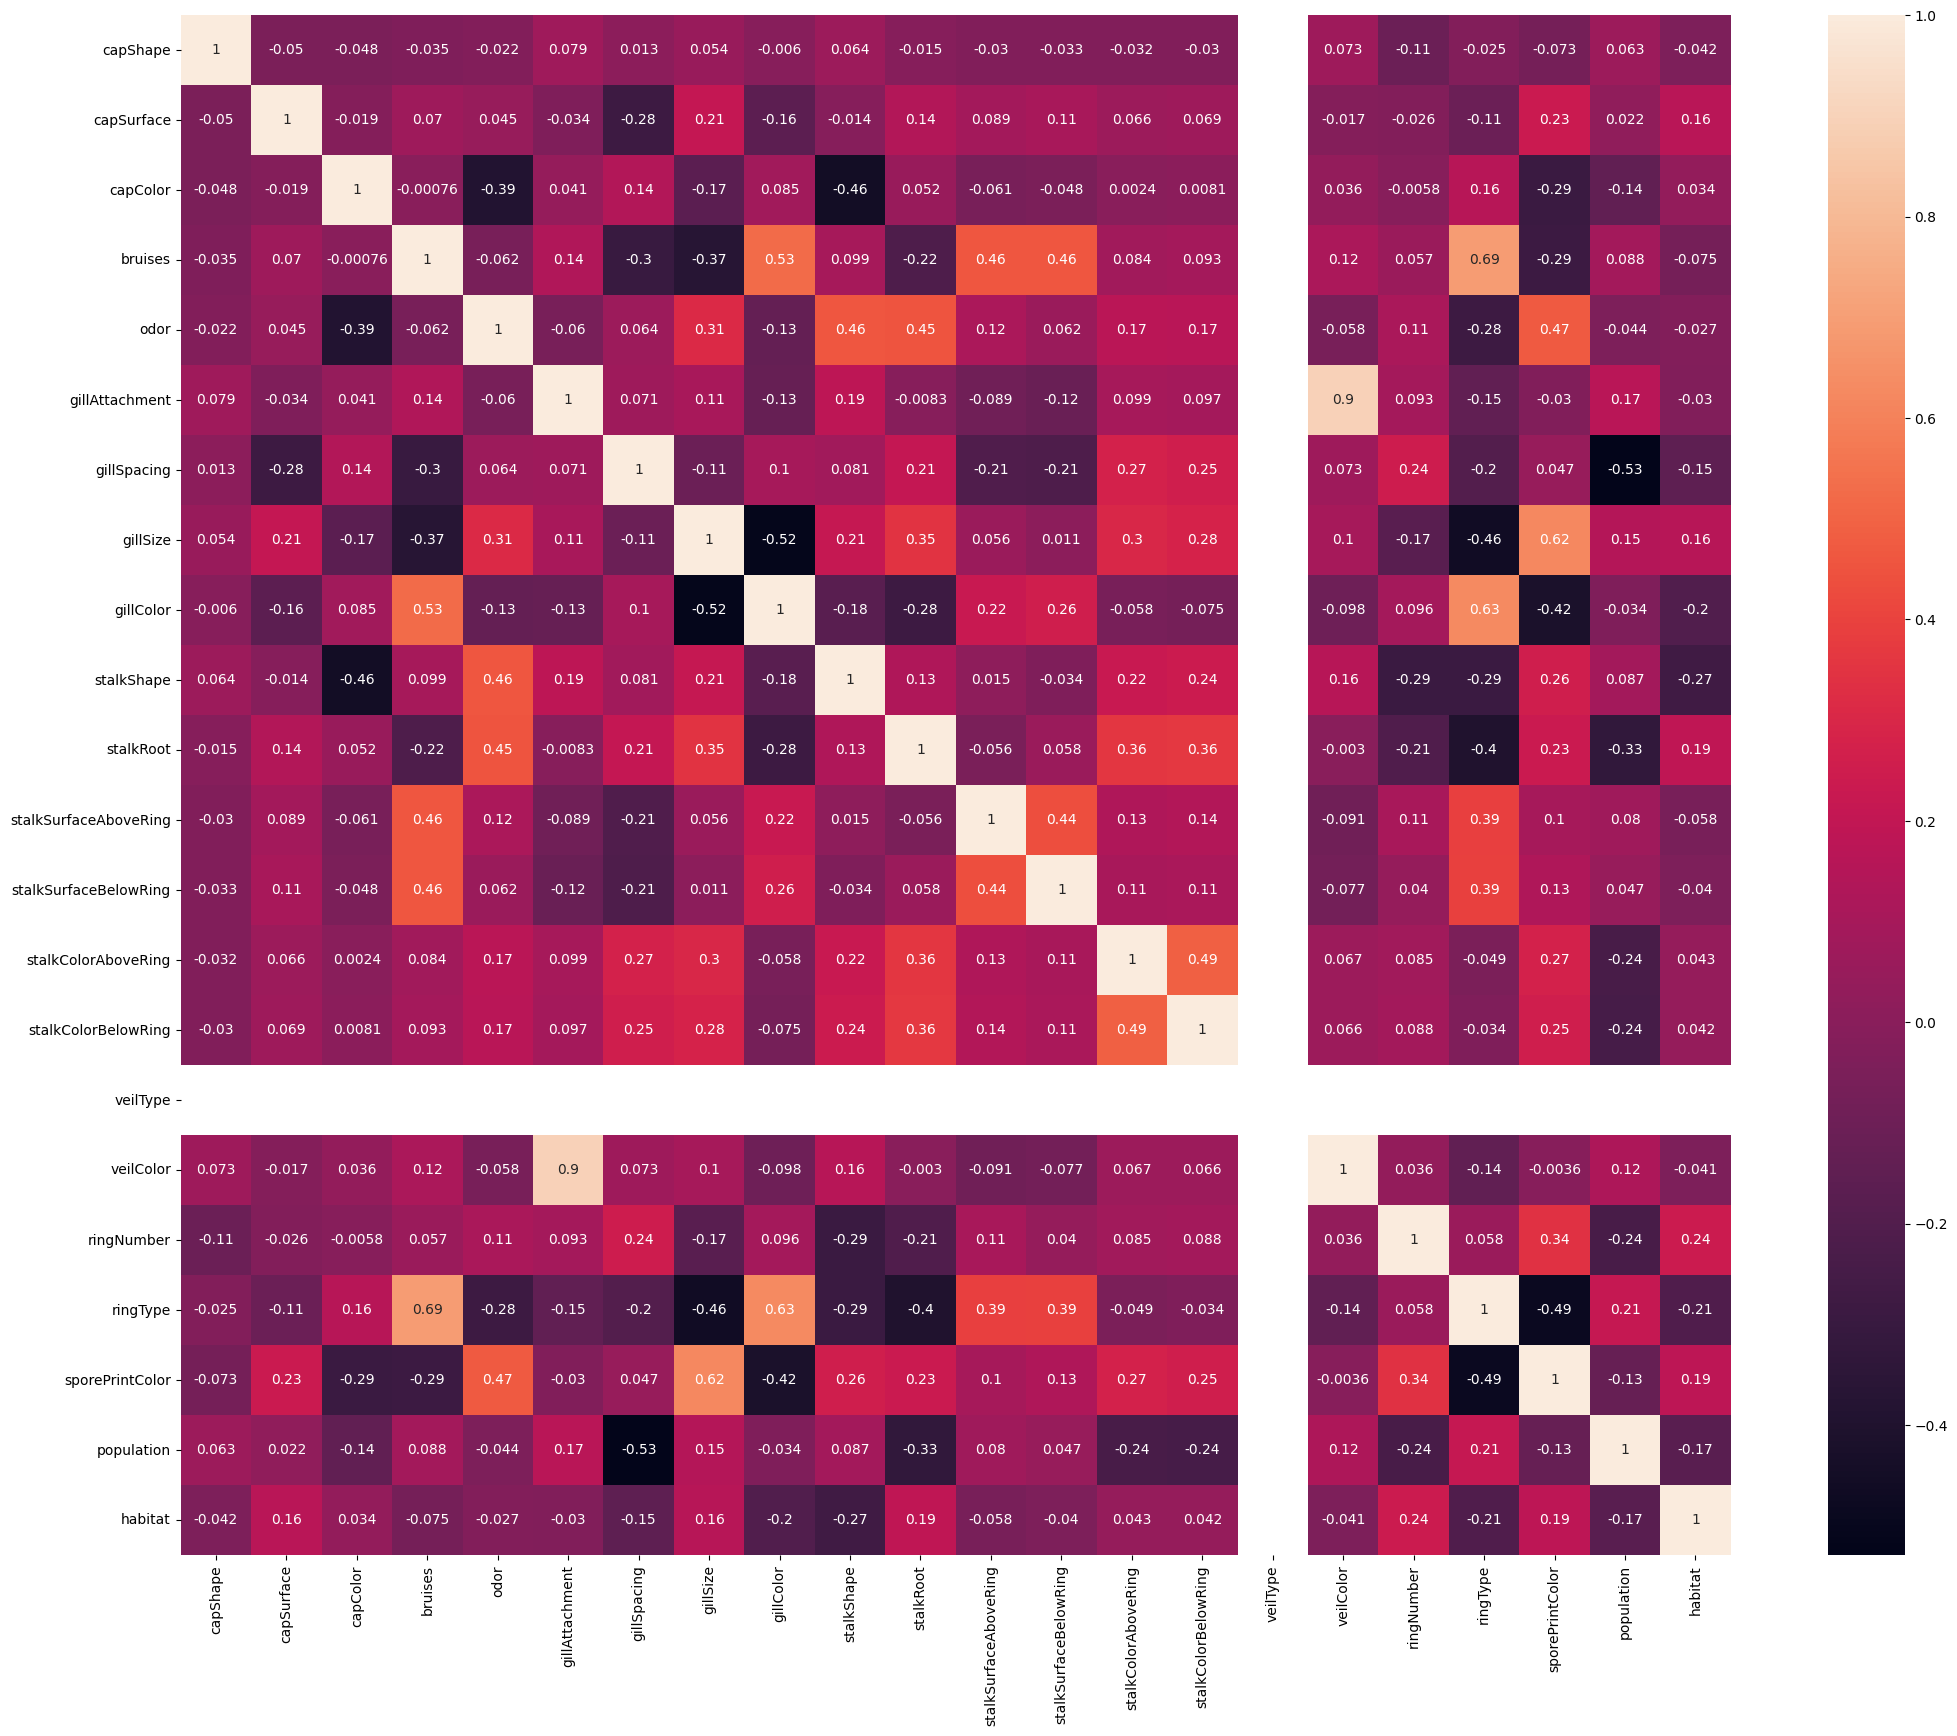

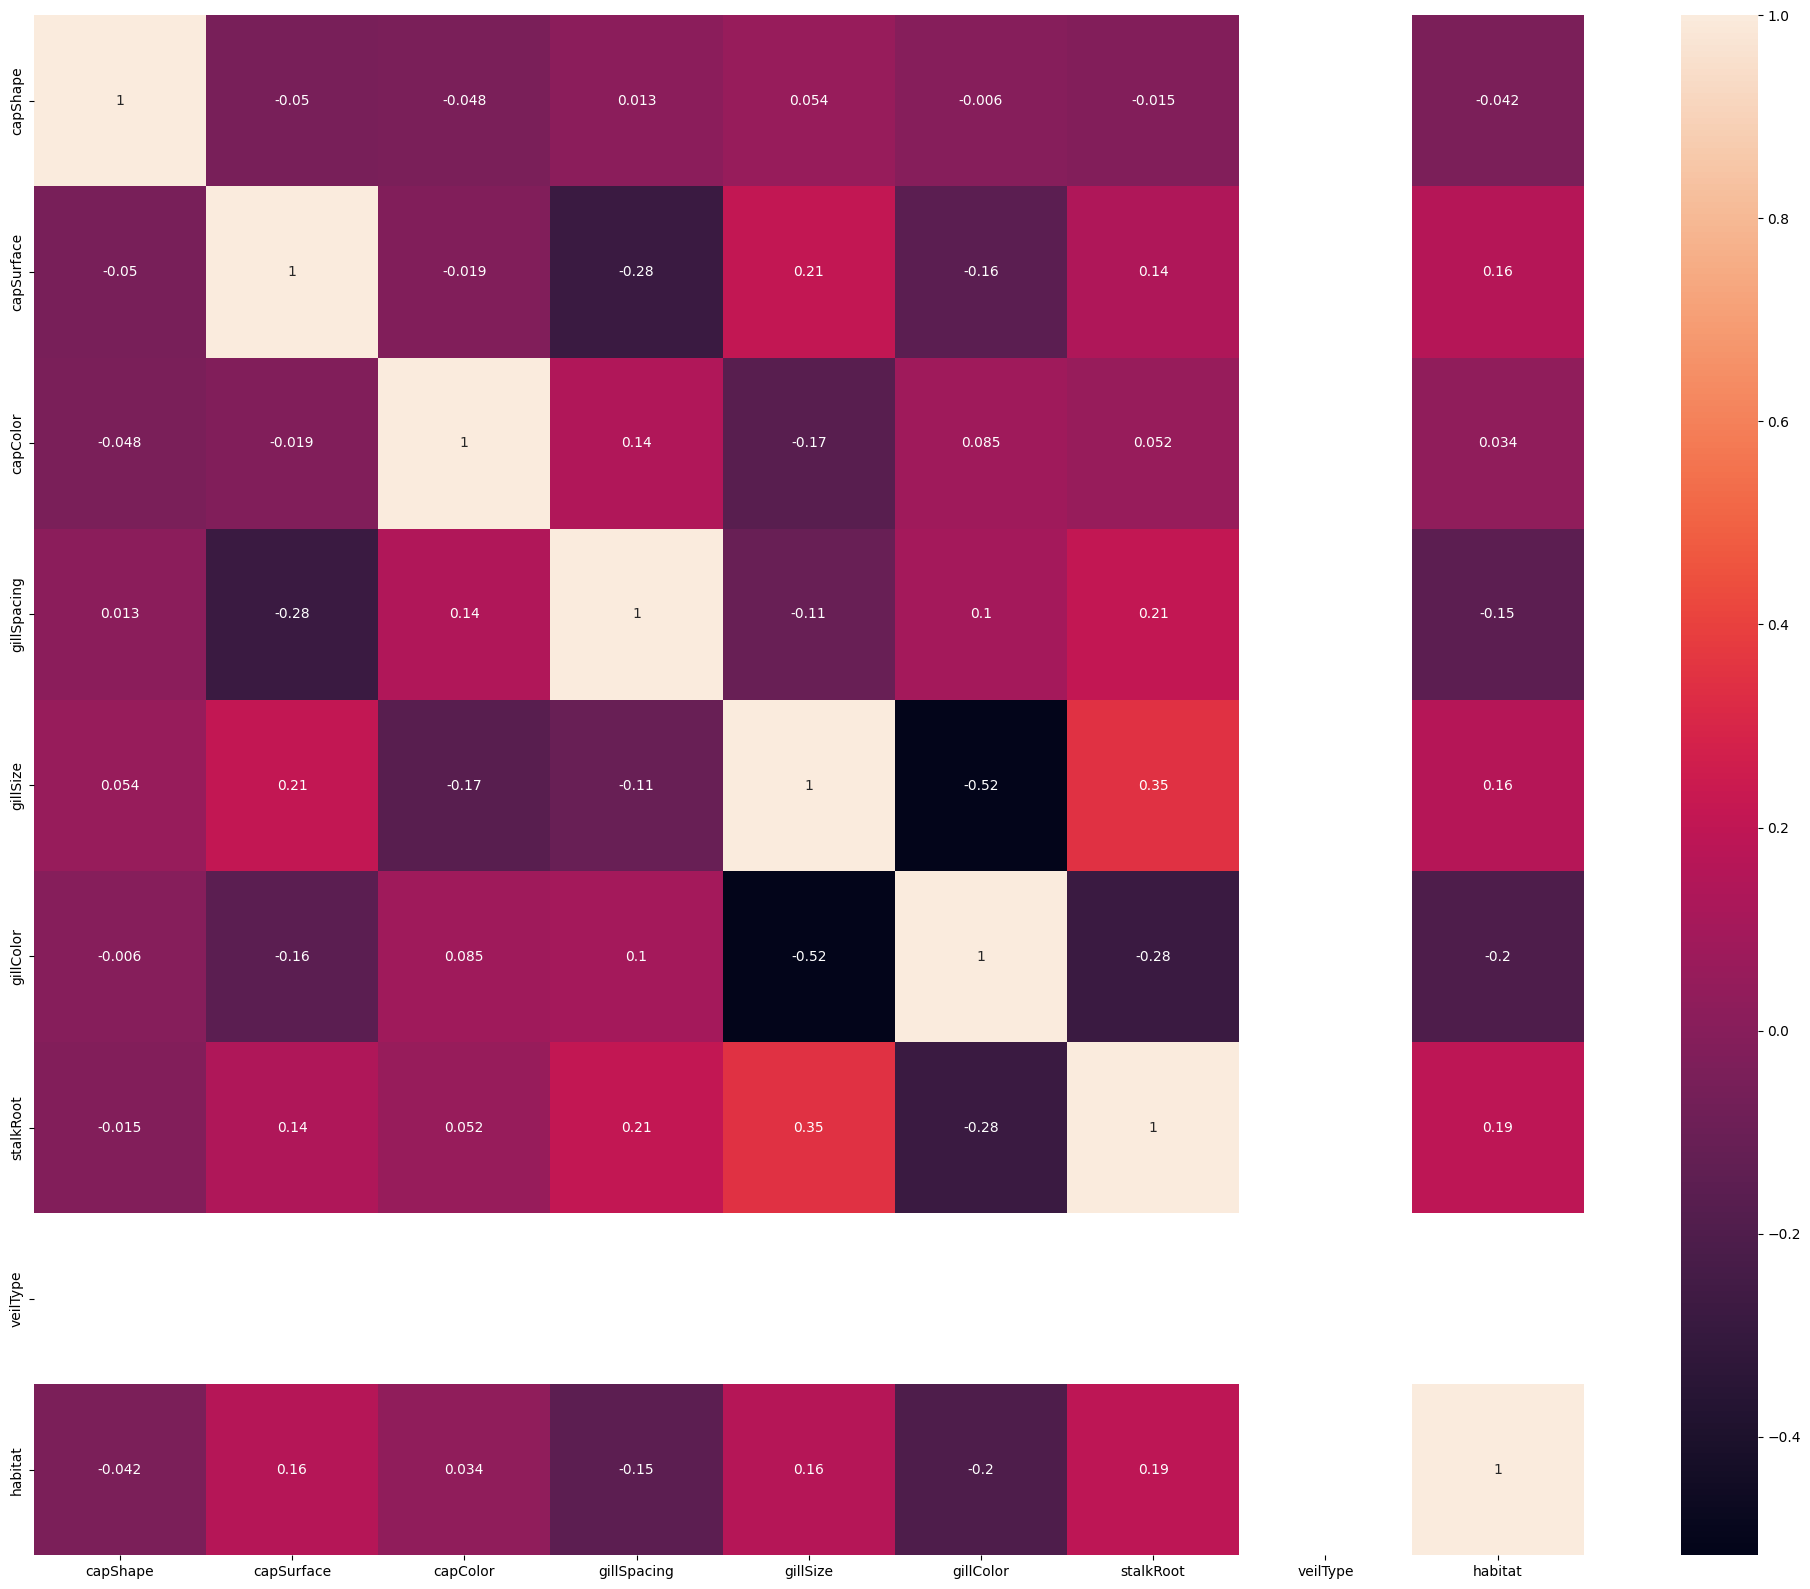

In [16]:
#variance inflation factor

fig = plt.figure(figsize=(25, 20))
sns.heatmap(X.corr(), annot=True)
plt.savefig("Heatmap.png")

#as you can see from heatmap there are some fearutes with high correlation

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
						for i in range(len(X.columns))]

print(vif_data)

features_to_drop = []

for i in range(len(X.columns)):
	if vif_data["VIF"][i] > 7:
		drop = vif_data["VIF"][i]
		features_to_drop.append(vif_data["feature"][i])
	
uncorrelated_X = X.drop(features_to_drop, axis = 1).reset_index(drop=True)

uncorrelated_X_scaled = StandardScaler().fit_transform(uncorrelated_X)

#generally features with VIF > 5 get removed but we can experiment with slightly higher i.e > 7

fig2 = plt.figure(figsize=(25, 20))
sns.heatmap(uncorrelated_X.corr(), annot=True)
plt.savefig("Heatmap2.png")

#as seen by second heatmap these have much less colinearality

__Data Visualisation__

In [ ]:
#data visualisation pca
#a linear method so less complex than tsne thus takes much less time
#not very useful to visualise our dataset I dont think as shown by the explained variance and scree plot
pca = PCA(random_state=42)
pca_features = pca.fit_transform(data_scaled)

per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
print(per_var)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

#to be seen on a 2D-plot we can only use PC1 and PC2 which gives us the highest explained variance but still very low
#around 19% + 12% = 31% explained variance which is bad
plt.bar(x= range(1,len(per_var)+1), height = per_var, tick_label = labels)
plt.show()

pca_df = pd.DataFrame({'pca_1': pca_features[:,0], 'pca_2': pca_features[:,1], 'label': treated_data['edibility']})
print(pca_df)

sns.scatterplot(x = 'pca_1', y = 'pca_2', hue = 'label', data = pca_df)

plt.show()

#PCA could be useful to reduce multicolinearality though instead of data visualisation
#use the first 8 pc's to get about ~90% explained variance, 9 to get ~93%, 10 to get ~95%

In [ ]:
#PCA 3D
pca = PCA(n_components = 3, random_state=42)
pca_features = pca.fit_transform(data_scaled)

per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
print(per_var)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

pca_df = pd.DataFrame({'pca_1': pca_features[:,0], 'pca_2': pca_features[:,1], 'pca_3': pca_features[:,2], 'label': treated_data['edibility']})

edible = pca_df[pca_df['label'] == 0]
poisonous = pca_df[pca_df['label'] == 1]

colors=['b', 'r'] 

fig = plt.figure(1)

ax = fig.add_subplot(111, projection='3d')


p1 = ax.plot(edible['pca_1'], 
             edible['pca_2'], 
             edible['pca_3'], 
             'o', color=colors[0],                                 
             alpha = 0.6, label='edible',                           
             markersize=3, 
             markeredgecolor='black',
             markeredgewidth=0.1)

p2 = ax.plot(poisonous['pca_1'], 
             poisonous['pca_2'], 
             poisonous['pca_3'], 
             'o', color=colors[1],                                 
             alpha = 0.6, label='poisonous',                           
             markersize=3, 
             markeredgecolor='black',
             markeredgewidth=0.1)

ax.set_xlabel('PCA-1, ' +  str(round(pca.explained_variance_ratio_[0]*100,2)) + '% Explained', fontsize=7)
ax.set_ylabel('PCA-2, ' +  str(round(pca.explained_variance_ratio_[1]*100,2)) + '% Explained', fontsize=7)
ax.set_zlabel('PCA-3, ' +  str(round(pca.explained_variance_ratio_[2]*100,2)) + '% Explained', fontsize=7)
#z label wont work not sure why its 10.7% explained

fig.legend(fontsize = 'x-small', loc='upper center', markerscale=2)
plt.autoscale()
plt.rcParams["figure.dpi"] = 1000                            
plt.show()

In [ ]:
#data visualisation t-sne 2D
#unlike pca its not linear so much more complex and better for our data I think
#result of t-sne greatly affected by 'perplexity' hyperparameter
#try perplexity values in the range 5-100 default is 30. Higher perplexity takes longer but may be better
n_components = 2
tsne = TSNE(n_components, perplexity=50)
tsne_features = tsne.fit_transform(data_scaled)

tsne_df = pd.DataFrame({'tsne_1': tsne_features[:,0], 'tsne_2': tsne_features[:,1], 'label': treated_data['edibility']})

sns.scatterplot(x = 'tsne_1', y = 'tsne_2', hue = 'label', data = tsne_df)

plt.show()

In [ ]:
#3D tsne using plotly
n_components = 3
tsne = TSNE(n_components, perplexity=50, random_state=42)
tsne_features = tsne.fit_transform(data_scaled)

treated_data["edibility"] = treated_data["edibility"].astype(str)

fig = px.scatter_3d(
    tsne_features, x=0, y=1, z=2,
    color=treated_data['edibility'], labels={'color': 'edibility'}
)
fig.update_traces(marker_size=8)
fig.show()

"""tsne = tsne = TSNE(n_components, perplexity=50, random_state = 42)
tsne_features = tsne.fit_transform(uncorrelated_X_scaled)

treated_data["edibility"] = treated_data["edibility"].astype(str)

fig = px.scatter_3d(
    tsne_features, x=0, y=1, z=2,
    color=treated_data['edibility'], labels={'color': 'edibility'}
)
fig.update_traces(marker_size=8)
fig.show()"""

treated_data["edibility"] = treated_data["edibility"].astype(int)

In [ ]:
#data visualisation UMAP
#UMAP works very similarly to tsne but get more efficient for higher volumes of data
#result greatly affected by n_neighbors and min_dist hyperparameters
#for n_neighbors try range 5-100 and min_dist 0.1-1
fit = umap.UMAP(
    n_neighbors=50,
    min_dist=0.25,
    n_components=2,
    metric = 'correlation',
    random_state = 42
)

umap_features = fit.fit_transform(data_scaled)

umap_df = pd.DataFrame({'umap_1': umap_features[:,0], 'umap_2': umap_features[:,1], 'label': treated_data['edibility']})

sns.scatterplot(x = 'umap_1', y = 'umap_2', hue = 'label', data = umap_df)

plt.show()

In [ ]:
#UMAP 3D using plotly
fit = umap.UMAP(
    n_neighbors=50,
    min_dist=0.25,
    n_components=3,
    metric = 'correlation',
    random_state = 42
)

umap_features = fit.fit_transform(data_scaled)

treated_data["edibility"] = treated_data["edibility"].astype(str)

fig_3d = px.scatter_3d(
    umap_features, x=0, y=1, z=2,
    color=treated_data['edibility'], labels={'color': 'edibility'}
)
fig_3d.update_traces(marker_size=5)

fig_3d.show()


"""fit = umap.UMAP(
    n_neighbors=50,
    min_dist=0.25,
    n_components=3,
    metric = 'correlation',
    random_state = 42
)

umap_features = fit.fit_transform(uncorrelated_X_scaled)

treated_data["edibility"] = treated_data["edibility"].astype(str)

fig_3d = px.scatter_3d(
    umap_features, x=0, y=1, z=2,
    color=treated_data['edibility'], labels={'color': 'edibility'}
)
fig_3d.update_traces(marker_size=5)

fig_3d.show()"""

treated_data["edibility"] = treated_data["edibility"].astype(int)

__Models__ 

In [17]:
# knn
# baseline_X, baseline_y stores baseline data
# X, y stores processed data

# first baseline model
X_train, X_test, y_train, y_test = train_test_split(baseline_X, baseline_y, test_size=0.2)

knn = KNeighborsClassifier(n_neighbors=1) # hyperparameter: n_neighbors 

knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

# knn_rounded = (np.rint(knn_pred)).astype(int)
print(classification_report(y_test,knn_pred)) # evaluate model performance


# now use processed data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

knn = KNeighborsClassifier(n_neighbors=1) # hyperparameter: n_neighbors 

knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

# knn_rounded = (np.rint(knn_pred)).astype(int)
print(classification_report(y_test,knn_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       873
           1       1.00      1.00      1.00       752

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       854
           1       1.00      1.00      1.00       771

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

